In [1]:
SNAKE_QTABLE_PATH = '/content/gdrive/MyDrive/snake.qtable.json.gz'
SNAKE_QSTORY_PATH = SNAKE_QTABLE_PATH[:30] + 'qstory.chckpnt.json'

In [2]:
from google.colab import drive
drive.mount(SNAKE_QTABLE_PATH[:15])

Mounted at /content/gdrive


In [4]:
md5 = !md5sum 'snake_game.py'
assert 'fe6f1b08c885095e7425b25c5a7ad9e5' == md5[0].split()[0]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
import gzip
import hashlib
from snake_game import SnakeGame
from datetime import datetime, timedelta

## Step 1: Create the environment 🎮
- Here we'll create the FrozenLake environment. 
- OpenAI Gym is a library <b> composed of many environments that we can use to train our agents.</b>
- In our case we choose to use Frozen Lake.

In [6]:
env = SnakeGame()

In [7]:
def extract_features(game=env):
  snake, food = game.get_state()
  obsticle = lambda k: copy.deepcopy(game).step(k).done
  obs = sum(v << i for i, v in enumerate(obsticle(k) for k in game.ACTION))
  return obs, snake.head.h, snake.head.w, food.h, food.w

In [8]:
extract_features()

(0, 0, 14, 7, 31)

## Step 2: Create the Q-table and initialize it 🗄️
Now, we'll create our Q-table, to know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size

In [9]:
def save_checkpoint(qtable, history):
  data = qtable.tolist(), history
  md5  = hashlib.md5()
  for part in data:
    for item in part:
      md5.update(json.dumps(item).encode())
  with open(SNAKE_QSTORY_PATH, 'w') as f:
    json.dump([data, md5.hexdigest()], f)
  !cp "$SNAKE_QSTORY_PATH" "$SNAKE_QSTORY_PATH".bak

In [10]:
def maybe_load_checkpoint():
  for candidate in SNAKE_QSTORY_PATH, SNAKE_QSTORY_PATH + '.bak':
    try:
      with open(candidate, 'r') as f:
        data, val_md5 = json.load(f)
      md5 = hashlib.md5()
      for part in data:
        for item in part:
          md5.update(json.dumps(item).encode())
      if val_md5 == md5.hexdigest():
        print('Qtable and history loaded from', candidate[24:], val_md5)
        qtable, history = data
        qtable = np.array(qtable)
        return qtable, history
    except:
      pass
  print("Training from scratch")
  action_space_size = len(env.ACTION)
  qtable = np.random.rand(
    1 << action_space_size,
    env.board_height, env.board_width,
    env.board_height, env.board_width,
    action_space_size)
  return qtable, []

In [11]:
qtable, history = maybe_load_checkpoint()
qtable.shape, qtable.size, len(history)

Qtable and history loaded from snake.qstory.chckpnt.json 6734b06ae619485145c0f8a968cb0c3d


((16, 16, 32, 16, 32, 4), 16777216, 54754507)

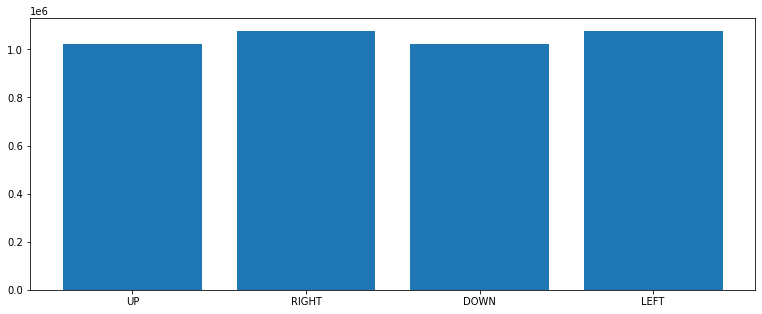

In [12]:
plt.rc('figure', figsize=(13, 5))
balance = [np.sum(qtable.argmax(axis=-1) == i.value) for i in env.ACTION]
plt.bar(range(len(balance)), balance, tick_label=[i.name for i in env.ACTION]) and None

## Step 3: Create the hyperparameters ⚙️
- Here, we'll specify the hyperparameters

In [13]:
ALPHA = 0.2                    # Learning rate
GAMMA = 0.9                    # Discounting rate

# Exploration parameters
max_epsilon = 1.0              # Exploration probability at start
min_epsilon = 0.01             # Minimum exploration probability 
epsilon_decay = 1e-07          # Exponential decay rate for exploration prob

## Step 4: The Q learning algorithm 🧠
- Now we implement the Q learning algorithm:
<img src="https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/qtable_algo.png?raw=1" alt="Q algo"/>

In [14]:
time_limit = timedelta(hours=11, minutes=30) # colab 12 hours limit
stop_time  = datetime.now() + time_limit

# 2 For life or until session time expired
while datetime.now() < stop_time:

  # Reset the environment
  env.reset()
  state = extract_features()
  done = False
  total_rewards = 0
  total_steps = 0

  # Reduce epsilon (because we need less and less exploration)
  epsilon = (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * len(history))
  epsilon += min_epsilon

  while not done:

    # 3. Choose an action a in the current world state (s)
    # First we randomize a number
    exp_exp_tradeoff = np.random.random()

    # If this number > greater than epsilon -->
    # exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
      action = np.argmax(qtable[state])

    # Else doing a random choice --> exploration
    else:
      action = env.random_action()

    # Take the action (a) and observe the outcome state(s') and reward (r)
    _, reward, done, info = env.step(action)
    new_state = extract_features()

    # Update Q(s,a):= Q(s,a) + lr * [R(s,a) + GAMMA * max Q(s',a') - Q(s,a)]
    # qtable[new_state,:] : all the actions we can take from new state
    i = state + (action,)
    qtable[i] += ALPHA * (reward + GAMMA * qtable[new_state].max() - qtable[i])

    total_rewards += reward
    total_steps += 1

    # Our new state is state
    state = new_state

  history.append((total_rewards, total_steps, info.score))
  if len(history) % 1000 == 0:
    h1k = zip(*history[-1000:])
    print('\r%7d' % (len(history) // 1000),
          '| Epsilon: %0.2f' % epsilon,
          '| Reward: %5.2f'  % np.average(next(h1k)),
          '| Age: %4d'       % np.average(next(h1k)),
          '| Score: %4d'     % np.average(next(h1k)),
          '| %d %%' % (100 * (1 - (stop_time - datetime.now()) / time_limit)),
          end = '')
    
save_checkpoint(qtable, history)

  55238 | Epsilon: 0.01 | Reward: 13.21 | Age:  184 | Score: 1251 | 99 %

In [15]:
history = np.array(history)
history.shape

(55238661, 3)

In [16]:
def plot_history(index, label):
  plt.rc('figure', figsize=(13, 4))
  plt.plot(history[:,index])
  plt.ylabel(label)
  plt.xlabel('Games')

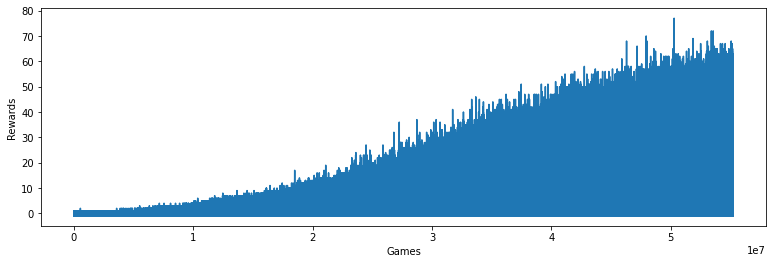

In [17]:
plot_history(0, 'Rewards')

In [18]:
plot_history(1, 'Steps')

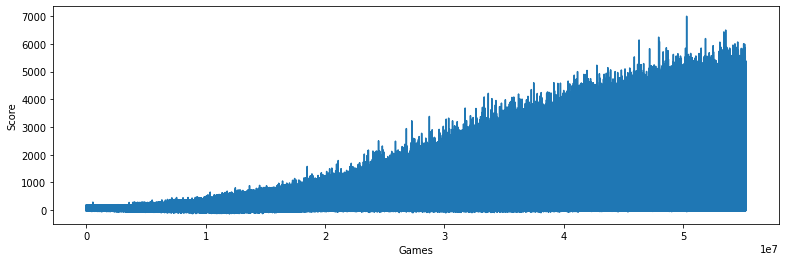

In [19]:
plot_history(2, 'Score')

In [20]:
with gzip.open(SNAKE_QTABLE_PATH, 'wt') as f:
  json.dump(qtable.argmax(axis=-1).tolist(), f)
!md5sum "$SNAKE_QTABLE_PATH"

8ecd7bb135420f8293c68ea51f7d1659  /content/gdrive/MyDrive/snake.qtable.json.gz
